In [ ]:

import os                   # for file and path operations
import cv2                  # for image loading and preprocessing
import numpy as np          # for numerical operations
import pandas as pd         # for CSV reading/manipulation
import tensorflow as tf     # for deep learning
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt  # for plotting


### Parameters & Paths

In [ ]:

#  Parameters & Paths
IMAGE_SIZE = 128      # smaller image size to save memory
BATCH_SIZE = 8        # batch size for training
EPOCHS = 3            # number of epochs (reduced to speed up)
TRAIN_DIR = "train_images"
TEST_DIR = "test_images"


In [27]:
train_df = pd.read_csv("train2.csv")
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [28]:
print("Number of training images:", len(train_df))

Number of training images: 147793


### Functions for parsing images & bounding boxes

In [29]:
# Parse images and convert bounding boxes to YOLO format
def parse_row(image_id, bbox, width, height):
    # Convert from TensorFlow tensor to Python types
    image_id = image_id.numpy().decode('utf-8')
    bbox = bbox.numpy().decode('utf-8')
    width = int(width.numpy())
    height = int(height.numpy())
    
    # Load image
    img_path = os.path.join(TRAIN_DIR, image_id + ".jpg")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255.0  # normalize
    
    # Convert bbox to YOLO format (x_center, y_center, width, height)
    x, y, w, h = eval(bbox)
    x_center = (x + w/2) / width
    y_center = (y + h/2) / height
    w_norm = w / width
    h_norm = h / height
    
    return img.astype(np.float32), np.array([x_center, y_center, w_norm, h_norm], dtype=np.float32)

def tf_parse(image_id, bbox, width, height):
    # TensorFlow wrapper for parse_row
    img, box = tf.py_function(parse_row, [image_id, bbox, width, height], [tf.float32, tf.float32])
    img.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    box.set_shape([4])
    return img, box


### Split data into training & validation

In [30]:
from sklearn.model_selection import train_test_split

# Split 80/20 for training and validation
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"Training images: {len(train_data)}, Validation images: {len(val_data)}")


Training images: 118234, Validation images: 29559


### Data Augmentation

In [31]:
# data augmentation for training images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # horizontal flips
    layers.RandomRotation(0.1),       # small rotations
])


### Create TensorFlow Datasets

In [32]:
# Create datasets
def create_dataset(df, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df['image_id'], df['bbox'], df['width'], df['height'])
    )
    ds = ds.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda img, box: (data_augmentation(img), box), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_dataset(train_data, augment=True)  # apply augmentation
val_dataset = create_dataset(val_data)                     # no augmentation


### Define the CNN Model

In [33]:
# Define a simple CNN model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='sigmoid')  # predicts bbox in YOLO format
])

# Compile model with mean squared error for bbox regression
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,100 (24.86 MB)

 Trainable params: 6,516,100 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [34]:
# Train the model on training dataset with validation
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)


Epoch 1/3
14780/14780 ━━━━━━━━━━━━━━━━━━━━ 1654s 112ms/step - loss: 0.0439 - val_loss: 0.0438
Epoch 2/3
14780/14780 ━━━━━━━━━━━━━━━━━━━━ 1661s 112ms/step - loss: 0.0438 - val_loss: 0.0438
Epoch 3/3
14780/14780 ━━━━━━━━━━━━━━━━━━━━ 1655s 112ms/step - loss: 0.0438 - val_loss: 0.0438


### Plot Training & Validation Loss

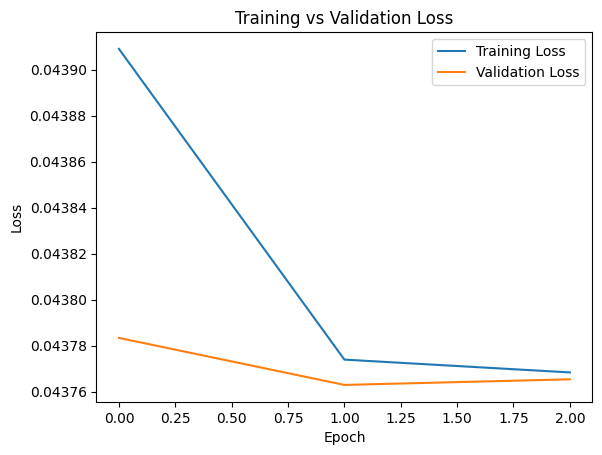

In [35]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


### Predict & Visualize Bounding Boxes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


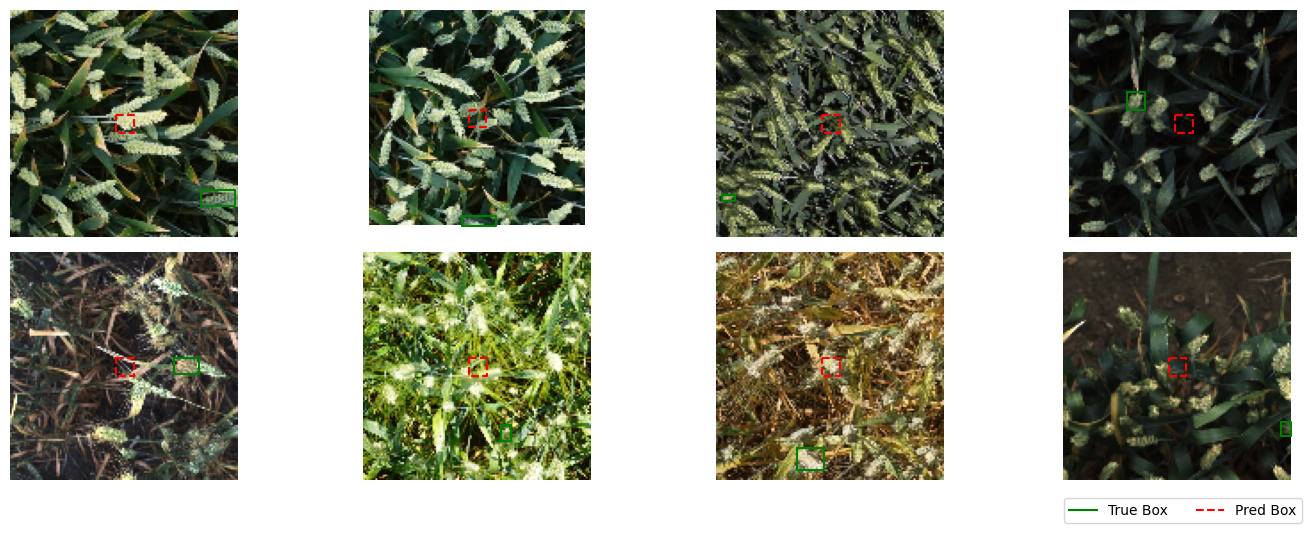

In [36]:
# Take the first batch from validation set and predict
for images, true_boxes in val_dataset.take(1):
    preds = model.predict(images)

# Function to convert YOLO bbox to pixel coordinates
def yolo_to_pixel(box, img_shape):
    h, w, _ = img_shape
    x_center, y_center, bw, bh = box
    x1 = int((x_center - bw/2) * w)
    y1 = int((y_center - bh/2) * h)
    x2 = int((x_center + bw/2) * w)
    y2 = int((y_center + bh/2) * h)
    return x1, y1, x2, y2

# Visualize predictions vs true boxes
plt.figure(figsize=(15,5))
for i in range(len(images)):
    img = images[i].numpy()
    true_box = true_boxes[i].numpy()
    pred_box = preds[i]
    
    # Convert to pixel coordinates
    x1_true, y1_true, x2_true, y2_true = yolo_to_pixel(true_box, img.shape)
    x1_pred, y1_pred, x2_pred, y2_pred = yolo_to_pixel(pred_box, img.shape)
    
    plt.subplot(2, BATCH_SIZE//2, i+1)
    plt.imshow(img)
    # True bbox in green solid line
    plt.plot([x1_true, x2_true, x2_true, x1_true, x1_true],
             [y1_true, y1_true, y2_true, y2_true, y1_true],
             'g-', label='True Box')
    # Predicted bbox in red dashed line
    plt.plot([x1_pred, x2_pred, x2_pred, x1_pred, x1_pred],
             [y1_pred, y1_pred, y2_pred, y2_pred, y1_pred],
             'r--', label='Pred Box')
    plt.axis('off')

plt.tight_layout()
plt.legend(['True Box', 'Pred Box'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()


### Prepare Test Dataset

In [40]:
# Load test image filenames from test_images folder
test_image_ids = [f.split(".")[0] for f in os.listdir(TEST_DIR) if f.endswith(".jpg")]
print(f"Number of test images: {len(test_image_ids)}")

# --- Corrected function for reading test images ---
def parse_test_row(image_id):
    # Convert tensor to string
    image_id = image_id.numpy().decode("utf-8")
    
    # Construct image path
    img_path = os.path.join(TEST_DIR, image_id + ".jpg")
    
    # Load and preprocess
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255.0
    return img.astype(np.float32)

def tf_parse_test(image_id):
    img = tf.py_function(parse_test_row, [image_id], tf.float32)
    img.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return img

# --- Build test dataset ---
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_ids)
test_dataset = test_dataset.map(tf_parse_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Number of test images: 10


### Predict on Test Set

In [41]:
test_preds = model.predict(test_dataset)
print("Test predictions shape:", test_preds.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Test predictions shape: (10, 4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


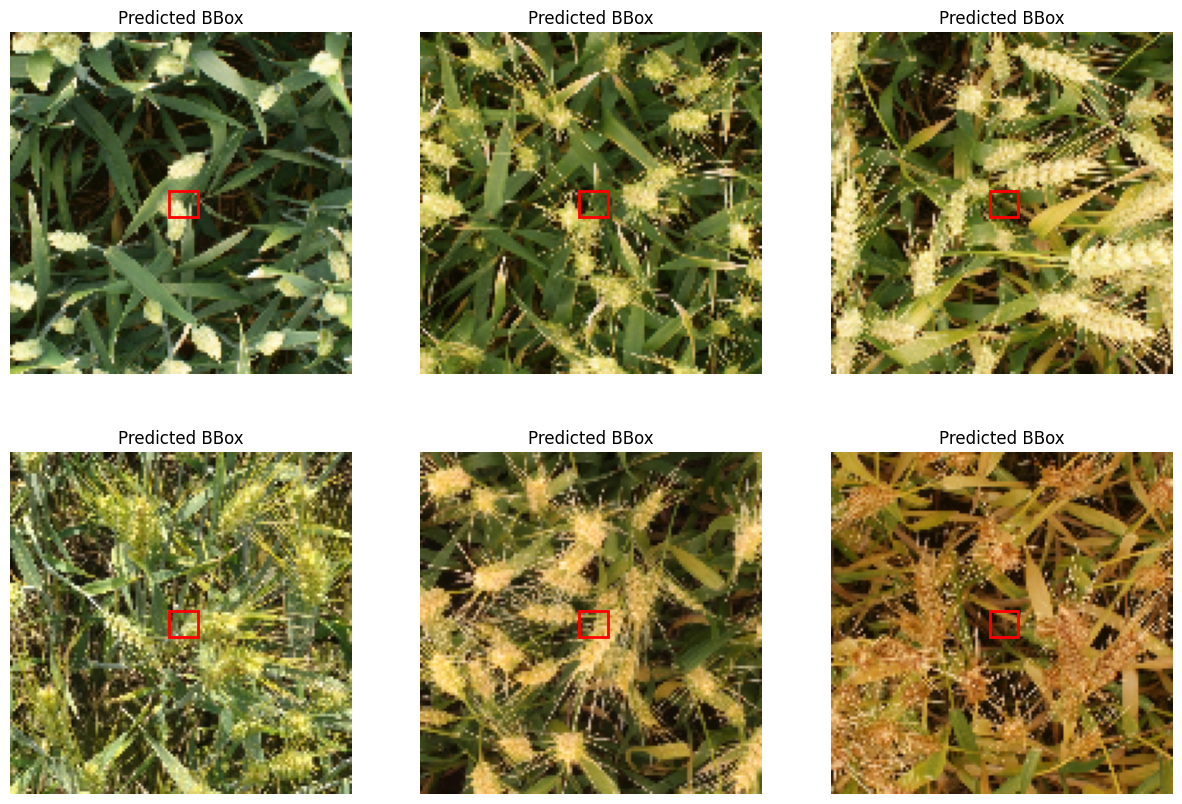

In [42]:
import matplotlib.pyplot as plt
import random

# Take a random batch from test dataset
for batch in test_dataset.take(1):
    preds = model.predict(batch)

    plt.figure(figsize=(15, 10))
    for i in range(min(6, len(batch))):  # show up to 6 test images
        img = batch[i].numpy()

        # Predicted bounding box in YOLO format (x_center, y_center, w, h)
        pred_box = preds[i]

        # Convert YOLO bbox back to pixel coordinates
        x_center, y_center, w, h = pred_box
        x_center *= IMAGE_SIZE
        y_center *= IMAGE_SIZE
        w *= IMAGE_SIZE
        h *= IMAGE_SIZE

        x1 = int(x_center - w/2)
        y1 = int(y_center - h/2)
        x2 = int(x_center + w/2)
        y2 = int(y_center + h/2)

        # Plot image and predicted box
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
        rect = plt.Rectangle((x1, y1), w, h, 
                             fill=False, color="red", linewidth=2)
        plt.gca().add_patch(rect)
        plt.title("Predicted BBox")

    plt.show()
